In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import klib
from matplotlib import dates as mpl_dates

from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Activation, LSTM
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [2]:
d = pd.read_csv('household_power_consumption.txt',sep=';')
d

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22892\3295178076.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv('household_power_consumption.txt',sep=';')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


In [3]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [4]:
# check null values

d.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [5]:
# checking the empty values 

(d[d['Voltage'] == '?'].index.value_counts().sum()/len(d))*100

1.2518437457686005

In [6]:
# lets replace them with Nan values

d = d.replace('?',np.nan,regex=False)
d.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [7]:
# let's add the time column into the date column 

d['Date'] = d['Date']+' '+d['Time']
d.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006 17:24:00,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006 17:25:00,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006 17:26:00,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006 17:27:00,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006 17:28:00,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [8]:
# first let's convert the data types into correct form and then handle the null values

d['Date'] = pd.to_datetime(d['Date'])
d['Global_active_power'] = d['Global_active_power'].astype('float')
d['Global_reactive_power'] = d['Global_reactive_power'].astype('float')
d['Voltage'] = d['Voltage'].astype('float')
d['Global_intensity'] = d['Global_intensity'].astype('float')
d['Sub_metering_1'] = d['Sub_metering_1'].astype('float')
d['Sub_metering_2'] = d['Sub_metering_2'].astype('float')
d.info()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22892\735198543.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  d['Date'] = pd.to_datetime(d['Date'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   datetime64[ns]
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Sub_metering_1         float64       
 7   Sub_metering_2         float64       
 8   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 142.5+ MB


In [9]:
d.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [10]:
# we can remove the Time column since its already in date column

d.drop(['Time'],axis=1,inplace=True)
d.columns

Index(['Date', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [11]:
# lets rename the date column with year 

d.rename(columns= {'Date':'Year'},inplace=True)
d.columns

Index(['Year', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [12]:
d.set_index('Year',inplace=True)
d.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Year,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [13]:
# let's use interpoling to handle null values

d = d.ffill(axis=0)
d[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']].fillna(value=d[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']].mean(),inplace=True)
d = d.interpolate()
d.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [15]:
round(d.describe(include='all'), 2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00
mean,1.09,0.12,240.84,4.60,1.11,1.29,6.42
std,1.05,0.11,3.24,4.43,6.12,5.79,8.42
min,0.08,0.00,223.20,0.20,0.00,0.00,0.00
25%,0.31,0.05,239.00,1.40,0.00,0.00,0.00
50%,0.60,0.10,241.02,2.60,0.00,0.00,1.00
75%,1.52,0.19,242.87,6.40,0.00,1.00,17.00
max,11.12,1.39,254.15,48.40,88.00,80.00,31.00


In [16]:
# lets resample the data

hourly = d.resample('H').mean()
daily = d.resample('D').mean()
weekly = d.resample('W').mean()
monthly = d.resample('M').mean()
Quarterly = d.resample('Q').mean()
yearly = d.resample('Y').mean()

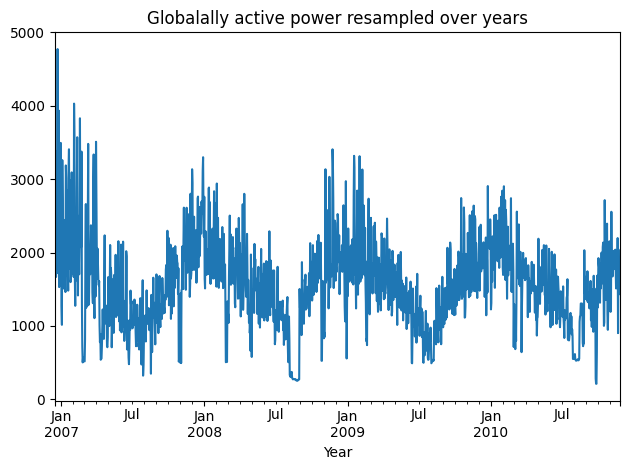

In [29]:
# Firstly, forward-fill all the missing values.Resample the data from a minute sampling rate to an hourly sampling rate (i.e sum over 
# the minutes for each hour). Which of the following is a plot of the hourly global_active_power over time?

d['Global_active_power'].resample('D').sum().plot(title='Globalally active power resampled over years')
plt.tight_layout()
plt.show() 

In [30]:
# What is the Pearson correlation coefficient between the global_active_power and voltage? To 3 decimal places
# What is the Pearson correlation coefficient between the Voltage and global_intensity? To 2 decimal places.
klib.corr_mat(d)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.00,0.25,-0.40,1.00,0.48,0.43,0.64
Global_reactive_power,0.25,1.00,-0.11,0.27,0.12,0.14,0.09
Voltage,-0.40,-0.11,1.00,-0.41,-0.19,-0.17,-0.26
Global_intensity,1.00,0.27,-0.41,1.00,0.49,0.44,0.63
Sub_metering_1,0.48,0.12,-0.19,0.49,1.00,0.06,0.10
Sub_metering_2,0.43,0.14,-0.17,0.44,0.06,1.00,0.08
Sub_metering_3,0.64,0.09,-0.26,0.63,0.10,0.08,1.00


In [31]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [33]:
values = d.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.374796   0.300719   0.376090   0.377593        0.0     0.0125   
2   0.478363   0.313669   0.336995   0.473029        0.0     0.0125   
3   0.479631   0.358273   0.326010   0.473029        0.0     0.0250   
4   0.480898   0.361151   0.340549   0.473029        0.0     0.0125   
5   0.325005   0.379856   0.403231   0.323651        0.0     0.0125   

   var7(t-1)   var1(t)  
1   0.548387  0.478363  
2   0.516129  0.479631  
3   0.548387  0.480898  
4   0.548387  0.325005  
5   0.548387  0.311787  


In [34]:
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 7) (8760,) (2066498, 1, 7) (2066498,)


In [36]:
model = Sequential()
model.add(keras.layers.InputLayer(input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(units=10, activation=None, use_bias=False,
                    kernel_initializer='glorot_uniform',
                    recurrent_initializer='orthogonal', bias_initializer='zeros', 
                    kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None,
                    activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None,
                    bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, 
                    return_sequences=False, return_state=False, go_backwards=False, 
                    stateful=False, unroll=False))

model.add(Dense(1))

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [37]:
from keras.optimizers import RMSprop
opt = RMSprop()
model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['mae'])

In [38]:
batch_size = 80
epochs = 20
history=model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs,
              validation_data=(test_X, test_y),
              shuffle=False)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 352ms/step - loss: 0.0287 - mae: 0.1315 - val_loss: 0.0057 - val_mae: 0.0578
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 335ms/step - loss: 0.0114 - mae: 0.0866 - val_loss: 0.0040 - val_mae: 0.0505
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 323ms/step - loss: 0.0075 - mae: 0.0714 - val_loss: 0.0024 - val_mae: 0.0389
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 33s 298ms/step - loss: 0.0050 - mae: 0.0574 - val_loss: 0.0016 - val_mae: 0.0297
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 324ms/step - loss: 0.0037 - mae: 0.0467 - val_loss: 0.0013 - val_mae: 0.0250
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 329ms/step - loss: 0.0033 - mae: 0.0408 - val_loss: 0.0011 - val_mae: 0.0228
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 34s 311ms/step - loss: 0.0030 - mae: 0.0374 - val_loss: 0.0010 - val_mae: 0.0215
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 331ms/step - loss: 0.0029 - mae: 0.0350 - val_loss: 9.5213e-04 - val_mae: 0.0206
Epoch 9/20
110/110 ━━━━━━━━━

In [39]:
Y_train_pred = model.predict(train_X)
Y_test_pred = model.predict(test_X)

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
64579/64579 ━━━━━━━━━━━━━━━━━━━━ 90s 1ms/step


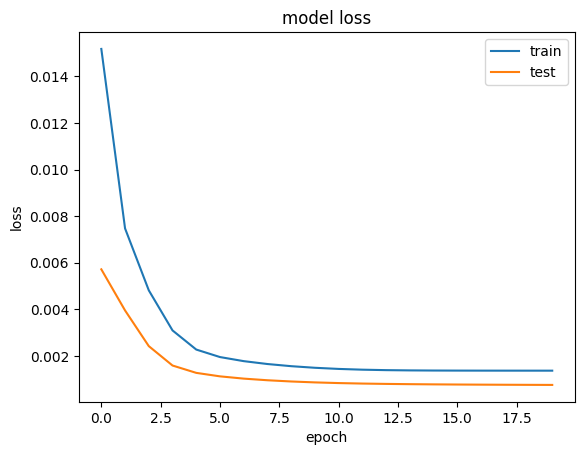

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [42]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

64579/64579 ━━━━━━━━━━━━━━━━━━━━ 94s 1ms/step
Test RMSE: 0.303
